# Order and Online customer behavior using RFM Analysis

In [1]:
# All basic imports
import numpy as np
import pandas as pd
import os
from datetime import datetime
from datetime import timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12,8]
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
onlineData = pd.read_csv("online.csv")
orderData = pd.read_csv("order.csv")

# Exploration and understanding of the data sets

In [3]:
onlineData.head()

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [4]:
orderData.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


My Assumptions is that online browsing category is our target variable. Our objective is to create a data set by merging online session activies to its corresponding conversion result in orders table and use the attribtues of converstion information to train a predictive model.

Vistiors ids are the devices used by the respective customer to interact with the website or the mobile application. Session ids are the session keys which indentify the session inactivity. If user does not interact for more than 30 mins a new session key is created for that visitor id if the customers has chosen to return to the site or the application.

In [5]:
print(" There are in total " + str(len(onlineData.custno.unique())) + " unique customers in online data")
print(" There are in total " + str(len(orderData.custno.unique())) + " unique customers in orders data")

 There are in total 57584 unique customers in online data
 There are in total 70264 unique customers in orders data


In [6]:
# created a separate columns for data and time for future use

onlineData['date'] = onlineData.dt.apply(lambda x : x[0:10])
onlineData['time'] = onlineData.dt.apply(lambda x : x[11:])

orderData['date'] = orderData.orderdate.apply(lambda x : x[0:10])
orderData['time'] = orderData.orderdate.apply(lambda x : x[11:])

In [7]:
# deleting the datetimes columns

del orderData['orderdate']
del onlineData['dt']

There are various instances where an order does not have the session activity info in the online data, for instance:

### Custno 1

In [8]:
#Result 1
onlineData[(onlineData.custno == 1) ]

,session,visitor,custno,category,event1,event2,date,time


In [9]:
#Result 2
orderData[(orderData.custno == 1)]

,custno,ordno,prodcat2,prodcat1,revenue,date,time
4,1,1,NaN,1,8.35,2017-06-12,08:27:59


Example of an instance which has the online active data on the same day by online activity was logged after order was purchased

### Custno 637

In [10]:
#Result 1
onlineData[(onlineData.custno == 637) & (onlineData.date == "2017-10-04")]

,session,visitor,custno,category,event1,event2,date,time
71874,9,405166,637,2,NaN,3,2017-10-04,13:36:14
135720,9,405166,637,2,NaN,7,2017-10-04,13:07:03


In [11]:
#Result 2
orderData[(orderData.custno == 637) & (orderData.date == "2017-10-04")]

,custno,ordno,prodcat2,prodcat1,revenue,date,time
153499,637,84765,25.0,7,68.48,2017-10-04,02:08:35
166738,637,151367,30.0,3,119.46,2017-10-04,13:47:35


If you refer the result 2 index 153499, there was no online activity logged before that order. Whereas in result 1 we see that there are two activites logged within 30 mins period having same session id. 

Later there was a purchase made by the customer on 13:47:35, approximately after 10 mins.

Therefore, I will be keeping only the records which has the online session data after merging order and online table.

In [12]:
data = pd.merge(onlineData, orderData,  how='outer', left_on=['custno','date'], right_on = ['custno','date'])

In [13]:
def timeDiff(x,y):
    format = '%H:%M:%S'
    return (datetime.strptime(x, format) - datetime.strptime(y, format))

def sameSession(x):
    if(x.seconds < 1800):
        return 1
    else:
        return 0

In [14]:
data.shape

(1196649, 13)

In [15]:
data.head()

,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y
0,419542.0,140970.0,3840,1.0,NaN,1.0,2016-09-16,05:03:23,NaN,NaN,NaN,NaN,NaN
1,3030130.0,14501.0,70400,1.0,NaN,1.0,2017-11-13,04:58:12,NaN,NaN,NaN,NaN,NaN
2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23
3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23
4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23


In [16]:
data = data[data.time_y.notnull()]

In [17]:
data = data[data.time_x.notnull()]

In [18]:
data.shape

(107164, 13)

In [19]:
data['timeDiff'] = data.apply(lambda x: timeDiff(x['time_y'],x['time_x']), axis = 1)

In [20]:
data['sameSession'] = data['timeDiff'].apply(lambda x : sameSession(x))

In [21]:
data.shape

(107164, 15)

In [22]:
data = data[data.sameSession == 1 ]

In [23]:
data['timediff'] = data['timeDiff'].apply(lambda x: x.seconds)

In [24]:
data.shape

(32803, 16)

In [25]:
data.head()

,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y,timeDiff,sameSession,timediff
2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23,00:04:45,1,285
3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23,00:04:45,1,285
4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23,00:04:45,1,285
82,301695.0,393923.0,3844,1.0,2.0,1.0,2016-08-17,18:30:01,42965.0,28.0,7.0,33.98,18:33:05,00:03:04,1,184
83,301695.0,393923.0,3844,1.0,2.0,1.0,2016-08-17,18:30:01,42965.0,94.0,7.0,50.02,18:33:05,00:03:04,1,184


In [26]:
len(data.custno.unique())

10323

In [27]:
data = data.reset_index()

In [28]:
data.head()

,index,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y,timeDiff,sameSession,timediff
0,2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23,00:04:45,1,285
1,3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23,00:04:45,1,285
2,4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23,00:04:45,1,285
3,82,301695.0,393923.0,3844,1.0,2.0,1.0,2016-08-17,18:30:01,42965.0,28.0,7.0,33.98,18:33:05,00:03:04,1,184
4,83,301695.0,393923.0,3844,1.0,2.0,1.0,2016-08-17,18:30:01,42965.0,94.0,7.0,50.02,18:33:05,00:03:04,1,184


In [29]:
del data['index']

In [30]:
data.dtypes

session                float64
visitor                float64
custno                   int64
category               float64
event1                 float64
event2                 float64
date                    object
time_x                  object
ordno                  float64
prodcat2               float64
prodcat1               float64
revenue                float64
time_y                  object
timeDiff       timedelta64[ns]
sameSession              int64
timediff                 int64
dtype: object

In [31]:
data['date'] = pd.to_datetime(data['date'])

In [32]:
data = data.sort_values('session')

----------

In [33]:
max(data.date) - min(data.date)

Timedelta('730 days 00:00:00')

## RFM data Creation


#### behavior dataset -  Total Revenue per session and Total products purchased

In [90]:
temp = data.groupby(['session']).sum()

In [91]:
temp = temp.sort_index()

In [92]:
temp.head()

,visitor,custno,category,event1,event2,ordno,prodcat2,prodcat1,revenue,sameSession,timediff
session,,,,,,,,,,,
9.0,405166.0,637,2.0,NaN,3.0,151367.0,30.0,3.0,119.46,1,681
21.0,383763.0,69508,2.0,NaN,4.0,148458.0,13.0,4.0,105.21,1,150
32.0,278715.0,4008,2.0,NaN,7.0,81006.0,50.0,7.0,25.40,1,428
55.0,1398237.0,9294,6.0,NaN,12.0,10887.0,112.0,3.0,56.22,3,810
77.0,50632.0,3844,2.0,NaN,8.0,153500.0,44.0,3.0,38.83,1,1042


In [93]:
behaviorData = temp[['revenue','sameSession']]

In [94]:
behaviorData.head()

,revenue,sameSession
session,,
9.0,119.46,1
21.0,105.21,1
32.0,25.40,1
55.0,56.22,3
77.0,38.83,1


#### Add customer id to behavior data

In [95]:
temp = data[['session','custno']]

In [96]:
temp = temp.drop_duplicates()

In [97]:
temp.index = temp.session

In [98]:
temp.head()

,session,custno
session,,
9.0,9.0,637
21.0,21.0,69508
32.0,32.0,4008
55.0,55.0,3098
77.0,77.0,3844


In [99]:
behaviorData['custno'] = temp['custno']

In [100]:
behaviorData.head()

,revenue,sameSession,custno
session,,,
9.0,119.46,1,637
21.0,105.21,1,69508
32.0,25.40,1,4008
55.0,56.22,3,3098
77.0,38.83,1,3844


In [101]:
# Rename Columns
behaviorData.columns = ['revenue','countOfProducts','custno']

#### add date purchased in Behavior data

In [102]:
temp = data[['custno', 'date','session']]

In [103]:
temp = temp.drop_duplicates(['session'])

In [104]:
temp = temp.sort_values(['custno'])

In [105]:
temp.index = temp.session

In [106]:
temp.head()

,custno,date,session
session,,,
809678.0,8,2017-03-29,809678.0
3632314.0,8,2016-12-11,3632314.0
3189010.0,9,2016-05-20,3189010.0
842759.0,9,2016-05-21,842759.0
3467201.0,9,2017-10-29,3467201.0


In [107]:
behaviorData = behaviorData.sort_values(['custno'])

In [108]:
behaviorData['date'] = temp['date']

In [109]:
behaviorData.head()

,revenue,countOfProducts,custno,date
session,,,,
809678.0,327.47,5,8,2017-03-29
3632314.0,88.00,1,8,2016-12-11
3189010.0,208.86,4,9,2016-05-20
842759.0,809.36,6,9,2016-05-21
3467201.0,129.58,2,9,2017-10-29


In [110]:
behaviorData[behaviorData.isnull()].count()

revenue            0
countOfProducts    0
custno             0
date               0
dtype: int64

In [111]:
behaviorData.head()

,revenue,countOfProducts,custno,date
session,,,,
809678.0,327.47,5,8,2017-03-29
3632314.0,88.00,1,8,2016-12-11
3189010.0,208.86,4,9,2016-05-20
842759.0,809.36,6,9,2016-05-21
3467201.0,129.58,2,9,2017-10-29


------

In [112]:
behaviorData = behaviorData.reset_index()

In [113]:
behaviorData.head()

,session,revenue,countOfProducts,custno,date
0,809678.0,327.47,5,8,2017-03-29
1,3632314.0,88.00,1,8,2016-12-11
2,3189010.0,208.86,4,9,2016-05-20
3,842759.0,809.36,6,9,2016-05-21
4,3467201.0,129.58,2,9,2017-10-29


### Exploratory Data Analysis

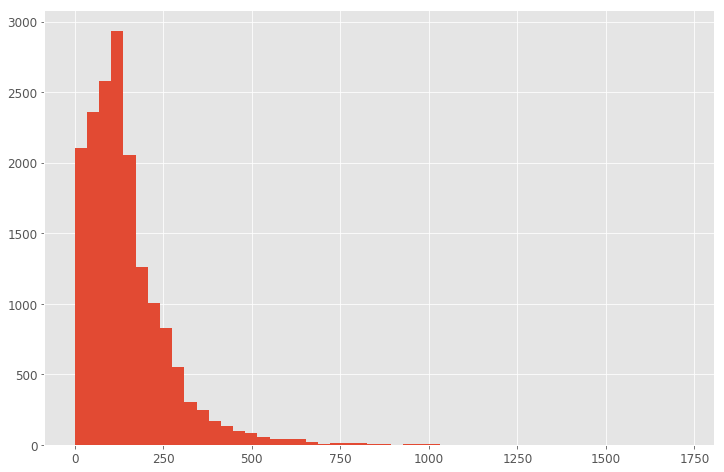

In [114]:
behaviorData.revenue.hist(bins= 50)
plt.show()

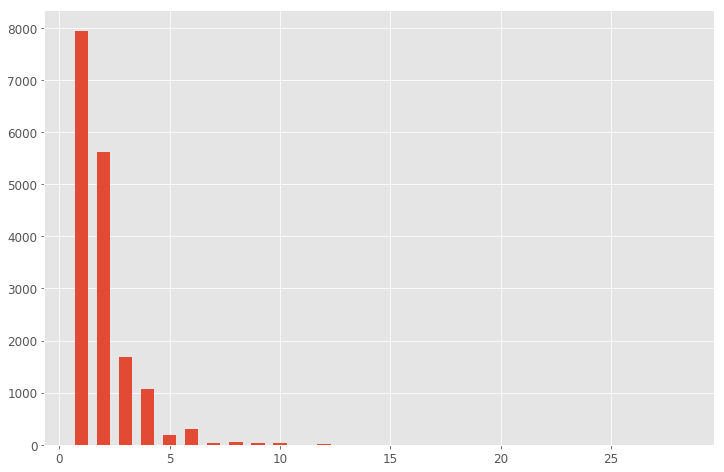

In [115]:
temp = behaviorData.groupby(['countOfProducts']).count()
plt.bar(temp.index, temp.session, width = 0.6)
plt.show()

-----

# Feature engineering and Feature selection

    Objective: To create a new dataset based to RFM metrics
    
    Recency - Rating based on number of days since last purschase
    
    3 -> 0   - 239   days
    2 -> 240 - 479   days
    1 -> 480 - above days
    
    Frequency - No of times the customers created a session
    
    3 -> 21 - above  Sessions
    2 -> 11 - 20     Sessions
    1 -> 1  - 10     Sessions
    
    Monetary - The average amount of spending per order
    
    3 -> 200 - above Revenue
    2 -> 79  - 199   Revenue
    1 -> 0   - 78    Revenue
    

    It is a batch learning process so we need to calibrate the metrics after a certian time

In [199]:
RFMData = pd.DataFrame(behaviorData['custno'].unique())

In [200]:
RFMData.head()

,0
0,8
1,9
2,11
3,15
4,17


In [201]:
RFMData.columns = ['custno']

In [202]:
RFMData.index = RFMData.custno

In [203]:
RFMData.head()

,custno
custno,
8,8
9,9
11,11
15,15
17,17


## Avg spending

In [204]:
temp = behaviorData.groupby(['custno']).mean()

In [205]:
temp.head()

,session,revenue,countOfProducts
custno,,,
8,2.220996e+06,207.73500,3.000000
9,2.155525e+06,217.47375,2.500000
11,2.351018e+06,97.67500,1.166667
15,3.478851e+06,68.42000,2.000000
17,8.579700e+05,190.04000,3.250000


In [206]:
behaviorData.head()

,session,revenue,countOfProducts,custno,date
session,,,,,
809678.0,809678.0,327.47,5,8,2017-03-29
3632314.0,3632314.0,88.00,1,8,2016-12-11
3189010.0,3189010.0,208.86,4,9,2016-05-20
842759.0,842759.0,809.36,6,9,2016-05-21
3467201.0,3467201.0,129.58,2,9,2017-10-29


In [207]:
RFMData['avgSpending'] = temp['revenue']

In [208]:
RFMData.head()

,custno,avgSpending
custno,,
8,8,207.73500
9,9,217.47375
11,11,97.67500
15,15,68.42000
17,17,190.04000


#### Frequency

In [209]:
temp = behaviorData.groupby(['custno']).count()

In [210]:
temp.head()

,session,revenue,countOfProducts,date
custno,,,,
8,2,2,2,2
9,8,8,8,8
11,6,6,6,6
15,1,1,1,1
17,4,4,4,4


In [211]:
RFMData['frequencyOfPurchase'] = temp['session']

In [212]:
RFMData.head()

,custno,avgSpending,frequencyOfPurchase
custno,,,
8,8,207.73500,2
9,9,217.47375,8
11,11,97.67500,6
15,15,68.42000,1
17,17,190.04000,4


### Recency

In [213]:
behaviorData.head()

,session,revenue,countOfProducts,custno,date
session,,,,,
809678.0,809678.0,327.47,5,8,2017-03-29
3632314.0,3632314.0,88.00,1,8,2016-12-11
3189010.0,3189010.0,208.86,4,9,2016-05-20
842759.0,842759.0,809.36,6,9,2016-05-21
3467201.0,3467201.0,129.58,2,9,2017-10-29


In [214]:
def countNoOfDays(date):
    latestDate = max(behaviorData['date'])
    diff = latestDate - date
    return diff.days

In [215]:
temp = behaviorData.groupby(['custno']).max()

In [216]:
behaviorData.index = behaviorData.session

In [217]:
RFMData['lastPurchase'] = temp['date'].apply(lambda x: countNoOfDays(x))

In [218]:
RFMData.head()

,custno,avgSpending,frequencyOfPurchase,lastPurchase
custno,,,,
8,8,207.73500,2,277
9,9,217.47375,8,63
11,11,97.67500,6,32
15,15,68.42000,1,617
17,17,190.04000,4,20


### Customer persona

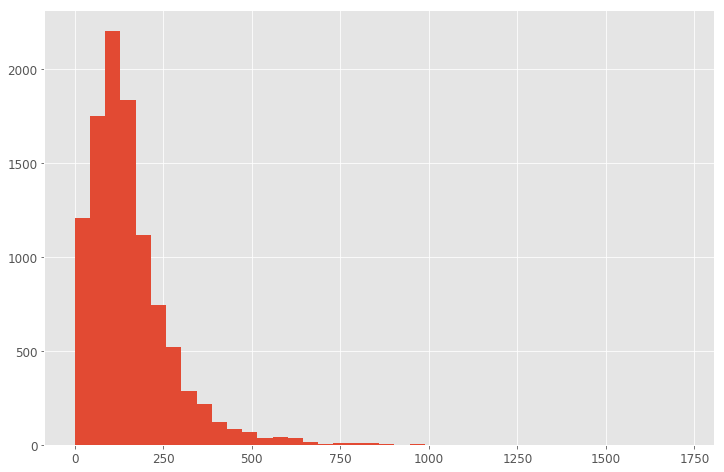

In [219]:
RFMData.avgSpending.hist(bins= 40)
plt.show()

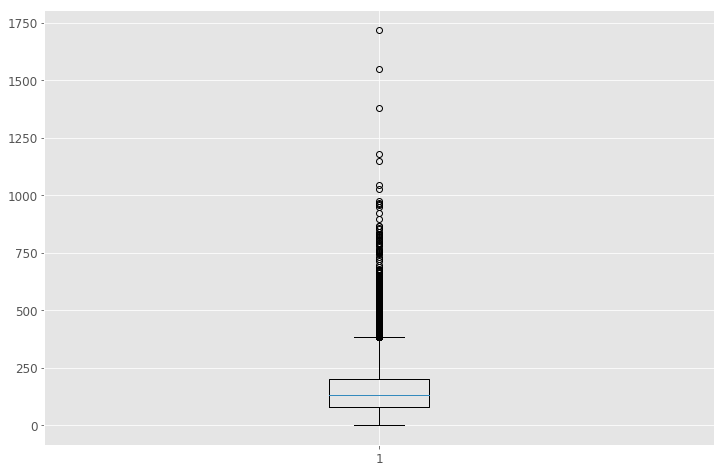

In [220]:
plt.boxplot(RFMData.avgSpending)
plt.show()

In [221]:
RFMData.avgSpending.describe()

count    10323.00000
mean       154.38965
std        119.63580
min          0.03000
25%         78.67000
50%        129.06500
75%        199.88500
max       1718.97000
Name: avgSpending, dtype: float64

In [222]:
def recency(x):
    if(x >= 0 and x < 240):
        return 3
    elif(x >= 240 and x < 480):
        return 2
    else:
        return 1

In [223]:
def frequency(x):
    if(x >= 0 and x <= 10):
        return 1
    elif(x >= 11 and x < 20):
        return 2
    else:
        return 3

In [224]:
def monetary(x):
    if(x >= 0 and x < 78):
        return 1
    elif(x >= 78 and x < 199):
        return 2
    else:
        return 3

In [225]:
RFMData['recency'] = RFMData.lastPurchase.apply(lambda x : recency(x))

In [226]:
RFMData['frequency'] = RFMData.frequencyOfPurchase.apply(lambda x : frequency(x))

In [227]:
RFMData['monetary'] = RFMData.avgSpending.apply(lambda x: monetary(x))

In [228]:
RFMData.head()

,custno,avgSpending,frequencyOfPurchase,lastPurchase,recency,frequency,monetary
custno,,,,,,,
8,8,207.73500,2,277,2,1,3
9,9,217.47375,8,63,3,1,3
11,11,97.67500,6,32,3,1,2
15,15,68.42000,1,617,1,1,1
17,17,190.04000,4,20,3,1,2


In [229]:
temp = RFMData[['recency','monetary','frequency']]

In [230]:
temp.drop_duplicates()

,recency,monetary,frequency
custno,,,
8,2,3,1
9,3,3,1
11,3,2,1
15,1,1,1
18,1,3,1
22,2,2,1
25,1,2,1
28,2,1,1
39,3,2,2


In [231]:
RFMData.shape

(10323, 7)

In [232]:
del RFMData['custno']

In [233]:
RFMData = RFMData.reset_index()

In [234]:
RFMData['type'] = 0
for i in RFMData.index:
     RFMData['type'][i] = str(str(RFMData['recency'][i])+str(RFMData['monetary'][i])+str(RFMData['frequency'][i])) 

In [235]:
len(RFMData.type.unique())

15

In [236]:
RFMData.head()

,custno,avgSpending,frequencyOfPurchase,lastPurchase,recency,frequency,monetary,type
0,8,207.73500,2,277,2,1,3,231
1,9,217.47375,8,63,3,1,3,331
2,11,97.67500,6,32,3,1,2,321
3,15,68.42000,1,617,1,1,1,111
4,17,190.04000,4,20,3,1,2,321


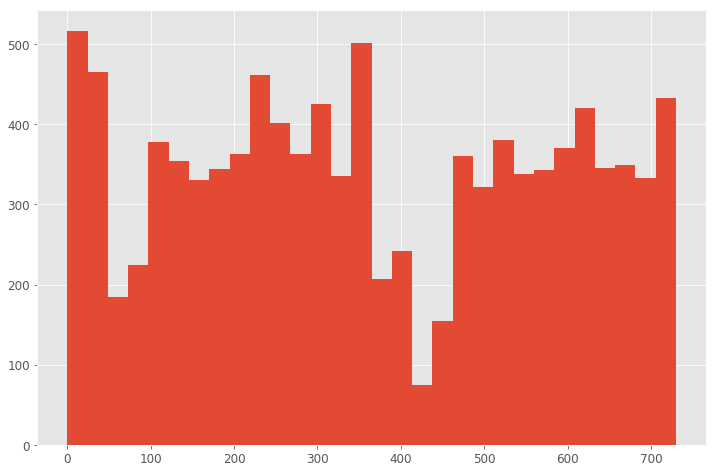

In [237]:
RFMData.lastPurchase.hist(bins= 30)

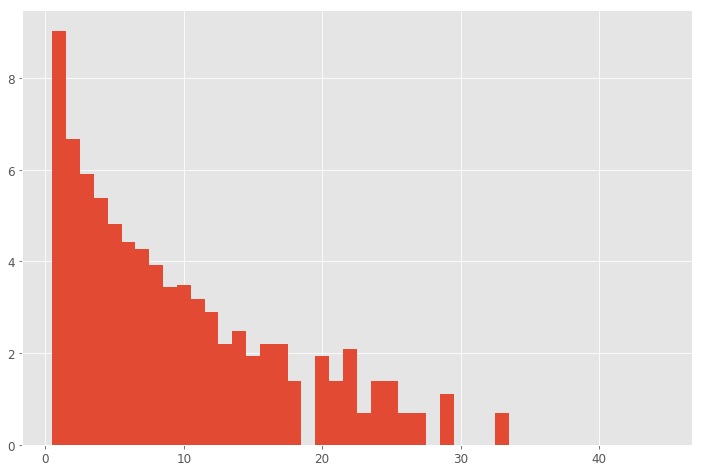

In [238]:
temp = RFMData.groupby(['frequencyOfPurchase']).count()
plt.bar(temp.index, np.log(temp.type), width = 1)
plt.show()

In [239]:
RFMData[['avgSpending','frequencyOfPurchase','lastPurchase','type']].corr()

,avgSpending,frequencyOfPurchase,lastPurchase,type
avgSpending,1.000000,-0.055377,-0.006588,0.067411
frequencyOfPurchase,-0.055377,1.000000,-0.313718,0.272742
lastPurchase,-0.006588,-0.313718,1.000000,-0.940238
type,0.067411,0.272742,-0.940238,1.000000


In [240]:
sc = StandardScaler()

In [241]:
sc.fit(RFMData)

StandardScaler(copy=True, with_mean=True, with_std=True)

## Model design and sampling


In [168]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [170]:
X = RFMData[['avgSpending', 'frequencyOfPurchase','lastPurchase']]

In [171]:
y = RFMData['type']

In [193]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state = 0)

In [244]:
from sklearn.linear_model import SGDClassifier

In [245]:
sgdCLF = SGDClassifier()

In [246]:
sgdCLF.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [247]:
y_pred = sgdCLF.predict(X_test)

In [249]:
from sklearn.metrics import accuracy_score, f1_score

In [250]:
accuracy_score(y_pred, y_test)

0.3280594123345173

In [253]:
f1_score(y_pred, y_test, average='weighted')

0.4173913886612494

In [294]:
from sklearn.metrics import confusion_matrix

In [292]:
cm  = confusion_matrix(y_pred,y_test)

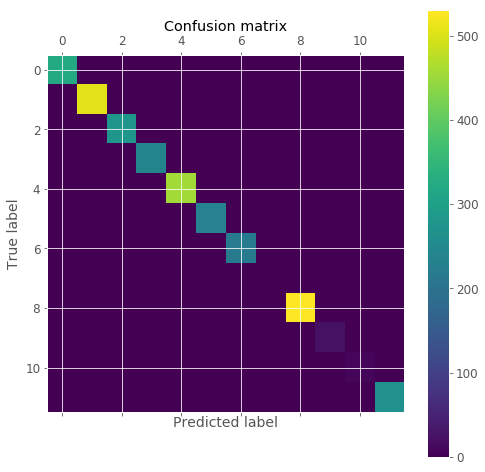

In [293]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [256]:
from sklearn.neighbors import KNeighborsClassifier

In [277]:
knnCLF = KNeighborsClassifier(n_neighbors= 2)

In [278]:
knnCLF.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [279]:
y_pred = knnCLF.predict(X_test)

In [280]:
accuracy_score(y_pred,y_test)

0.9622215046819502

In [281]:
confusion_matrix(y_pred,y_test)

array([[318,  11,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0],
       [  5, 494,   4,   0,   8,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 273,   0,   0,   5,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 233,   9,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   3, 437,   3,   0,   0,   1,   0,   0,   0],
       [  0,   1,   2,   0,   3, 226,   0,   0,   0,   0,   0,   5],
       [  0,   0,   0,   0,   0,   0, 220,   2,  11,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 518,  20,   2,   9],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   5,   5,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0, 255]],
      dtype=int64)

In [290]:
plot_confusion_matrix(y_pred,y_train)

NameError: name 'plot_confusion_matrix' is not defined

In [282]:
from sklearn.ensemble import RandomForestClassifier

In [283]:
RF_clf = RandomForestClassifier()

In [285]:
RF_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [287]:
y_pred = RF_clf.predict(X_test)

In [288]:
accuracy_score(y_pred,y_test)

0.999354213755247

In [295]:
from sklearn.naive_bayes import GaussianNB

In [296]:
NB_clf = GaussianNB()

In [299]:
NB_clf.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [300]:
y_pred = NB_clf.predict(X_test)

In [301]:
accuracy_score(y_pred,y_test)

0.8773006134969326

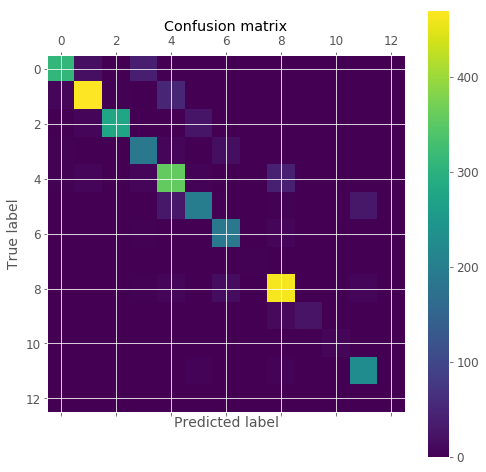

In [304]:
cm = confusion_matrix(y_pred,y_test)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [308]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_pred, y_test)

ValueError: multiclass format is not supported

## Model generation


In [307]:
import pickle

with open('NB_clf.pkl', 'wb') as fid:
    pickle.dump(NB_clf, fid)

## Model evaluation